In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from gensim.corpora import Dictionary
import string
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import LSTM
from sklearn.metrics import roc_auc_score
import boto3

2024-01-16 15:33:49.805194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 15:33:49.948241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-16 15:33:49.948266: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-01-16 15:33:49.984753: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 15:33:50.879312: W tensorflow/stream_executor/platform/de

In [14]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
s3 = boto3.client('s3')
response = s3.list_buckets()

In [8]:
response

{'ResponseMetadata': {'RequestId': 'RSTZWX19Z1NHE4B0',
  'HostId': 'BIpucu/Cf2/D9MJK3bHxsQdWt2AYtSGL7qA7aG2co2UQJZ3Cx0PTLt5TmrnJy2jHZAAsXIIzY6c=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'BIpucu/Cf2/D9MJK3bHxsQdWt2AYtSGL7qA7aG2co2UQJZ3Cx0PTLt5TmrnJy2jHZAAsXIIzY6c=',
   'x-amz-request-id': 'RSTZWX19Z1NHE4B0',
   'date': 'Tue, 16 Jan 2024 15:22:59 GMT',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Buckets': [{'Name': 'bucket-raw-data16012024',
   'CreationDate': datetime.datetime(2024, 1, 16, 11, 5, 24, tzinfo=tzlocal())}],
 'Owner': {'DisplayName': 'awslabsc0w5526977t1680220615',
  'ID': '2b1219a628bd6dd1359ef462f126229e4a6114704079943aa744ef8dc0d9d493'}}

In [2]:
s3 = boto3.resource('s3')
obj = s3.Object(bucket_name='bucket-raw-data16012024', key='sample.json')
response = obj.get()
data = response['Body'].read()

In [10]:
json_test = json.loads(data)

In [11]:
df_pd = pd.DataFrame(json_test)

In [13]:
df_pd

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
0,rw1133942,OriginalMovieBuff21,Kill Bill: Vol. 2 (2004),8,Good follow up that answers all the questions,24 July 2005,0,"After seeing Tarantino's Kill Bill Vol: 1, I g...","[0, 1]"
1,rw1133943,sentra14,Journey to the Unknown (1968– ),None,Excellent series,24 July 2005,0,"I have the entire series on video, taped mostl...","[11, 11]"
2,rw1133946,GreenwheelFan2002,The Island (2005),9,"Not just about action, but about survival...",24 July 2005,0,Once again the critics prove themselves as mor...,"[2, 5]"
3,rw1133948,itsascreambaby,Win a Date with Tad Hamilton! (2004),3,Falls under the category: seen it a million ti...,24 July 2005,0,This IS a film that has been done too many tim...,"[2, 3]"
4,rw1133949,OriginalMovieBuff21,Saturday Night Live: The Best of Chris Farley ...,10,"Before Tommy Boy and Black Sheep, there was Sa...",24 July 2005,0,Chris Farley is one of my favorite comedians a...,"[4, 4]"
...,...,...,...,...,...,...,...,...,...
99995,rw1251330,shaleina03,Brokeback Mountain (2005),10,Oscar Worthy,30 December 2005,0,This movie was amazing! Jake Gyllenhaal deserv...,"[14, 16]"
99996,rw1251331,DanB-4,Eternal Sunshine of the Spotless Mind (2004),9,The Most Original Romance Film I Have Seen,30 December 2005,0,"What a brilliant, original and challenging fil...","[0, 2]"
99997,rw1251332,marilutravis,Summer's Lease (1989– ),10,Summer's Lease,30 December 2005,0,My husband and I were mesmerized when we saw t...,"[7, 9]"
99998,rw1251333,NYCDude,Loggerheads (2005),10,"The Adoption Triad: The child, the birth mothe...",30 December 2005,1,"This is a beautiful, tightly written movie abo...","[4, 6]"


In [15]:
punc = string.punctuation

def wt(string):
    return [w.lower() for w in word_tokenize(string)
                if w.lower() not in punc]

review_detail_clear = df_pd['review_detail'].apply(wt)
dct = Dictionary(review_detail_clear)


tokens_in_dataset = 5000
document_max_len = 400
batch_size = 32
embedding_dim = 64

In [16]:
review_detail_clear

0        [after, seeing, tarantino, 's, kill, bill, vol...
1        [i, have, the, entire, series, on, video, tape...
2        [once, again, the, critics, prove, themselves,...
3        [this, is, a, film, that, has, been, done, too...
4        [chris, farley, is, one, of, my, favorite, com...
                               ...                        
99995    [this, movie, was, amazing, jake, gyllenhaal, ...
99996    [what, a, brilliant, original, and, challengin...
99997    [my, husband, and, i, were, mesmerized, when, ...
99998    [this, is, a, beautiful, tightly, written, mov...
99999    [so, i, was, bored, at, work, one, day, and, d...
Name: review_detail, Length: 100000, dtype: object

In [17]:
# w ponizszym kroku kodujemy tokeny za pomoca slownika, a nastepnie
# liczymy hashe (w uproszczony sposob), by ograniczyc wielkosc slownika do
# embeddingu
review_detail_idx = review_detail_clear.apply(lambda x: [y%tokens_in_dataset 
                                                         for y in dct.doc2idx(x)])

target = np.array(df_pd['spoiler_tag'].copy())

x_train, x_test, y_train, y_test = train_test_split(review_detail_idx,
                                                    target, test_size = 0.3,
                                                    random_state=12)

(array([444., 260., 114.,  80.,  39.,  24.,  11.,  13.,   7.,   8.]),
 array([  87. ,  181.6,  276.2,  370.8,  465.4,  560. ,  654.6,  749.2,
         843.8,  938.4, 1033. ]),
 <BarContainer object of 10 artists>)

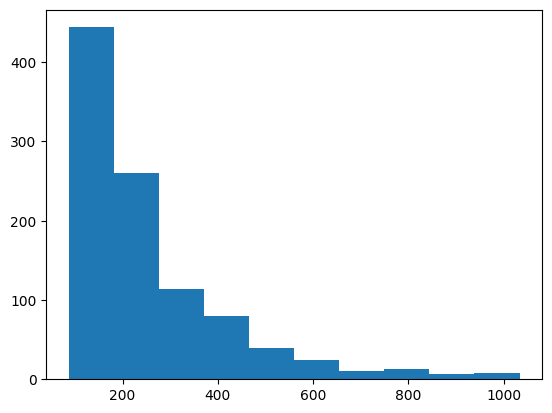

In [18]:
plt.hist([len(x_train.iloc[i]) for i in range(1000)])

In [19]:
x_train = sequence.pad_sequences(x_train, maxlen=document_max_len, padding='pre', truncating='post')
x_test = sequence.pad_sequences(x_test, maxlen=document_max_len, padding='pre', truncating='post')

In [20]:
model = Sequential()

model.add(Embedding(input_dim=tokens_in_dataset, # liczba unikalnych tokenów
                    output_dim=embedding_dim, # wielkość embeddingu
                    input_length=document_max_len, # długość sekwencji
                    ))
model.add(LSTM(units=32, activation='tanh', return_sequences=True))
model.add(LSTM(units=16, activation='tanh', return_sequences=False))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

es = EarlyStopping(patience=3, monitor='val_loss')
model.summary()

2024-01-16 15:46:06.349169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-16 15:46:06.349219: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-16 15:46:06.349262: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-89-90): /proc/driver/nvidia/version does not exist
2024-01-16 15:46:06.349646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 64)           320000    
                                                                 
 lstm (LSTM)                 (None, 400, 32)           12416     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 335,841
Trainable params: 335,841
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(x_train, y_train, batch_size=batch_size,
          callbacks=[es],
          validation_split=0.2,
          epochs=20)

Epoch 1/20


2024-01-16 15:46:23.406893: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89600000 exceeds 10% of free system memory.


1750/1750 [==============================] - 480s 272ms/step - loss: 0.5288 - accuracy: 0.7737 - val_loss: 0.5025 - val_accuracy: 0.7743
Epoch 2/20
1750/1750 [==============================] - 477s 273ms/step - loss: 0.5133 - accuracy: 0.7747 - val_loss: 0.5259 - val_accuracy: 0.7743
Epoch 3/20
1750/1750 [==============================] - 471s 269ms/step - loss: 0.4855 - accuracy: 0.7779 - val_loss: 0.4881 - val_accuracy: 0.7774
Epoch 4/20
1750/1750 [==============================] - 474s 271ms/step - loss: 0.4474 - accuracy: 0.7974 - val_loss: 0.4780 - val_accuracy: 0.7889
Epoch 5/20
1750/1750 [==============================] - 476s 272ms/step - loss: 0.4187 - accuracy: 0.8119 - val_loss: 0.4955 - val_accuracy: 0.7689
Epoch 6/20
1750/1750 [==============================] - 476s 272ms/step - loss: 0.3889 - accuracy: 0.8274 - val_loss: 0.5067 - val_accuracy: 0.7769
Epoch 7/20
1750/1750 [==============================] - 476s 272ms/step - loss: 0.3638 - accuracy: 0.8411 - val_loss: 0.538

In [22]:
model.evaluate(x_test,y_test)

938/938 [==============================] - 63s 67ms/step - loss: 0.5337 - accuracy: 0.7559


[0.5337475538253784, 0.7559000253677368]

In [23]:
prob_pred_train = model.predict(x_train)
prob_pred_test = model.predict(x_test)
AUC = {
       'train': roc_auc_score(y_train,prob_pred_train),
       'test': roc_auc_score(y_test,prob_pred_test),
       }

print(AUC)

2024-01-16 16:44:13.820221: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 112000000 exceeds 10% of free system memory.


938/938 [==============================] - 62s 66ms/step
{'train': 0.871267179678177, 'test': 0.6941233042764144}
